### Importando e setando configs

In [461]:
from dataclasses import dataclass, field

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


@dataclass
class Config:
  df_url: str = 'https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv'
  df_path: str = "ToLD-BR.csv"


config = Config()

### Baixando o dataset


In [462]:
!wget $config.df_url

--2023-07-04 21:00:32--  https://raw.githubusercontent.com/JAugusto97/ToLD-Br/main/ToLD-BR.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2430416 (2.3M) [text/plain]
Saving to: ‘ToLD-BR.csv.6’

ToLD-BR.csv.6       100%[===================>]   2.32M  --.-KB/s    in 0.07s   

2023-07-04 21:00:32 (31.2 MB/s) - ‘ToLD-BR.csv.6’ saved [2430416/2430416]



### Carregando dados

In [488]:
df = pd.read_csv(config.df_path)

df.head(5)

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0


In [489]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   text        21000 non-null  object 
 1   homophobia  21000 non-null  float64
 2   obscene     21000 non-null  float64
 3   insult      21000 non-null  float64
 4   racism      21000 non-null  float64
 5   misogyny    21000 non-null  float64
 6   xenophobia  21000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 1.1+ MB


In [490]:
df.describe()

,homophobia,obscene,insult,racism,misogyny,xenophobia
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,0.028286,0.460333,0.322429,0.008429,0.029762,0.009905
std,0.241548,0.770638,0.703540,0.112445,0.216954,0.129091
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


### EDA

### Pré processamento

In [493]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import RSLPStemmer
from nltk.tokenize import TweetTokenizer

nltk.download('stopwords')
nltk.download('rslp')


def remove_non_alpha(text):
    cleaned_text = ''.join(c for c in text if c.isalpha())
    return cleaned_text

def preprocess_portuguese_tweet(tweet):
    tweet = re.sub(r"http\S+|www\S+|https\S+", "", tweet)

    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(tweet)
    punctuation_filtered_tokens = [token for token in tokens if token not in string.punctuation]

    stop_words = set(stopwords.words("portuguese"))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]

    stemmer = RSLPStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

    tokens = [remove_non_alpha(t) for t in stemmed_tokens]
    tokens = list(filter(lambda x: (len(x) >= 3) and (len(x) <= 7), tokens))

    return np.array(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


In [494]:
df["text"] = df["text"].apply(preprocess_portuguese_tweet)
df.head(5)

,text,homophobia,obscene,insult,racism,misogyny,xenophobia
0,"[nivel, amizad, isil, ter, inst, ter, pens, ma...",0.0,0.0,2.0,0.0,0.0,0.0
1,"[car, adult, dad, aind, fic, govern]",0.0,0.0,1.0,0.0,0.0,0.0
2,"[car, simples, mai, venc, histór, futebol, ano...",0.0,2.0,1.0,0.0,0.0,0.0
3,"[chor, vei, vsf, stanei, izon, nad]",0.0,1.0,0.0,0.0,0.0,0.0
4,"[elei, tão, ignor, perceb, fras, abaix, signif...",0.0,1.0,2.0,0.0,0.0,0.0


<Axes: ylabel='Frequency'>

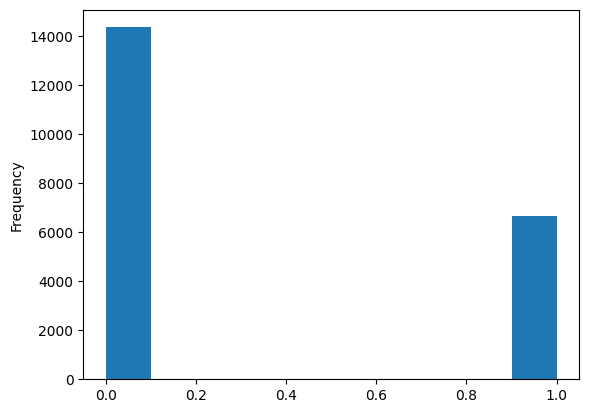

In [495]:
df["obscene"].apply(lambda x: min(1, x)).plot.hist()

In [504]:
@dataclass
class NaiveBayes:
  priors: dict = field(default_factory=dict)
  likelihoods: dict = field(default_factory=dict)
  alpha: int = 1


  def fit(self, X: np.array, y: np.array) -> None:
    assert X is not None
    assert X.dtype == np.dtype('O') # You should infer in an array of arrays
    assert y is not None

    n_samples = len(y)
    classes = np.unique(y)

    for cls in classes:
      self.priors[cls] = np.sum(y == cls) / n_samples
      self.likelihoods[cls] = dict()
      class_indexes = np.where(y==cls)[0]
      class_values = np.concatenate(X[class_indexes])
      unique, counts = np.unique(class_values, return_counts=True)
      for feature, count in zip(unique, counts):
        self.likelihoods[cls][feature] = (self.alpha + count) / len(class_values)

      for feature in np.unique(np.concatenate(X)):
        if feature not in self.likelihoods[cls]:
          self.likelihoods[cls][feature] = self.alpha / len(class_values)


  def predict(self, X: np.array) -> np.array:
    assert self.priors is not None  # You should fit first
    assert X.dtype == np.dtype('O') # You should infer in an array of arrays

    for cls in self.priors.keys():
      not_seen_value = min(self.likelihoods[cls].values())

    y_pred: list = []
    for sample in X:
      sample_probs = self.priors.copy()
      for cls in sample_probs.keys():
        for w in sample:
            sample_probs[cls] =  (
                sample_probs[cls]
                * self.likelihoods[cls].get(w, not_seen_value)
            )
      y_pred.append(max(sample_probs, key=sample_probs.get))

    return np.array(y_pred)


In [505]:
X = df["text"].values
y = df["obscene"].apply(lambda x: min(1, x)).values
# y = [int(any(a)) for a in df[["homophobia",	"obscene",	"insult", "racism",	"misogyny", "xenophobia"]].values]

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [507]:
model = NaiveBayes()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

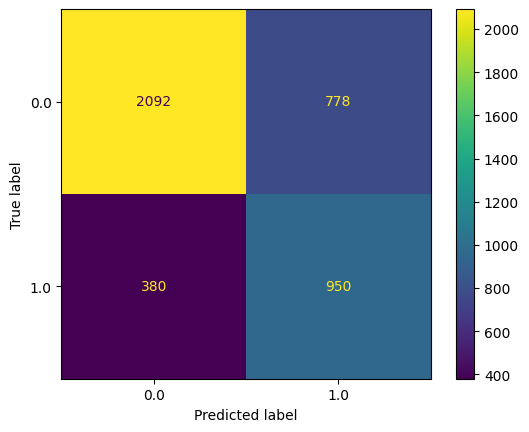

In [508]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [509]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.73      0.78      2870
         1.0       0.55      0.71      0.62      1330

    accuracy                           0.72      4200
   macro avg       0.70      0.72      0.70      4200
weighted avg       0.75      0.72      0.73      4200



In [510]:
model.likelihoods

{0.0: {'aaa': 0.0005753090876274705,
  'aaah': 0.00011280570345636675,
  'aaahahh': 2.2561140691273352e-05,
  'aaahhh': 3.3841711036910025e-05,
  'aaaoo': 2.2561140691273352e-05,
  'aaargh': 2.2561140691273352e-05,
  'aaf': 2.2561140691273352e-05,
  'aah': 2.2561140691273352e-05,
  'aahh': 2.2561140691273352e-05,
  'aakkk': 2.2561140691273352e-05,
  'aba': 2.2561140691273352e-05,
  'abacax': 3.3841711036910025e-05,
  'abaf': 3.3841711036910025e-05,
  'abaix': 0.0001917696958758235,
  'abal': 4.5122281382546704e-05,
  'abandon': 0.00018048912553018682,
  'abarc': 2.2561140691273352e-05,
  'abat': 2.2561140691273352e-05,
  'abcd': 2.2561140691273352e-05,
  'abduz': 2.2561140691273352e-05,
  'abdômen': 2.2561140691273352e-05,
  'abel': 0.00016920855518455014,
  'abelh': 4.5122281382546704e-05,
  'abenco': 2.2561140691273352e-05,
  'abenço': 0.00012408627380200343,
  'aben莽o': 2.2561140691273352e-05,
  'aberr': 0.00015792798483891344,
  'abert': 0.00020305026622146016,
  'abi': 2.256114069